<a href="https://colab.research.google.com/github/ybchen97/filler_detection/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

Syncing from google drive and github... for more info on this code, refer [here](https://zerowithdot.com/colab-github-workflow/)

In [1]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive

drive.mount(ROOT)           # we mount the drive at /content/drive

Mounted at /content/drive


In [2]:
GIT_PATH = "https://github.com/ybchen97/filler_detection.git"
!mkdir ./temp
!git clone "{GIT_PATH}"
!mv ./temp/* "{PROJECT_PATH}"
!rm -rf ./temp

Cloning into 'filler_detection'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 3993 (delta 70), reused 57 (delta 44), pack-reused 3887
Receiving objects: 100% (3993/3993), 189.60 MiB | 30.27 MiB/s, done.
Resolving deltas: 100% (248/248), done.
Checking out files: 100% (3603/3603), done.
mv: cannot stat './temp/*': No such file or directory


Install packages in this local notebook specified in requirements.txt

In [3]:
!pip install -r '/content/filler_detection/requirements.txt'

     |████████████████████████████████| 81kB 5.3MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 788kB 14.3MB/s 
     |████████████████████████████████| 378kB 24.9MB/s 
     |████████████████████████████████| 12.4MB 35kB/s 
     |████████████████████████████████| 20.2MB 162kB/s 
     |████████████████████████████████| 358kB 57.6MB/s 
     |████████████████████████████████| 1.3MB 54.6MB/s 
     |████████████████████████████████| 921kB 50.8MB/s 
     |████████████████████████████████| 276kB 62.3MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
     |████████████████████████████████| 421.8MB 33kB/s 
     |████████████████████████████████| 450kB 54.0MB/s 
     |████████████████████████████████| 133kB 63.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=cf65c07b26eb0c7595b8541020b4224cf0229bf0e7d5a20d67df10eff44da1cb
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378

Importing and setting up env variables...

In [0]:
import numpy as np
from pydub import AudioSegment
from pydub.playback import play
import random
import sys
import io
import os
import glob
import IPython
import wave
import pylab
from tf_utils import *
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import pickle

# Import files for trigger-word detection model
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

In [0]:
PROJ_PATH = '/content/drive/My Drive/filler_detection/'

The fun begins...
## Model Loading

Sanity check for `Tx`, `n_freq`, `Ty`. 

1. Input into model `Tx` and `n_freq`
2. Call `model.summary()`
3. `Tx` of **sample** and variable = `input_7.shape[1]` (ie column 2, row 1, second element of array)
4. `Ty` = `input_7.shape[1]` (ie column 2, row 2, second element of array)

In [0]:
Tx = 5490 # The number of time steps input to the model from the spectrogram
n_freq = 129 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 1369 # The number of time steps in the output of our model

### Load Pre-trained Model

In [17]:
model = load_model(PROJ_PATH + "models/random_ratio_model.h5") 
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5490, 129)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1369, 196)         379456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1369, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 1369, 196)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1369, 196)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1369, 128)         124800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1369, 128)         0   

### Create New Model (if not pre-trained)

In [0]:
from keras.initializers import RandomNormal

# GRADED FUNCTION: model

def create_model(input_shape, output_bias=None):
    """
    Function creating the model's graph in Keras library.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    
    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV Layer
    # CONV-1D
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)
    # Batch Normalization
    X = BatchNormalization()(X)
    # RelU activation
    X = Activation("relu")(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=0.8)(X)
    
    # Step 2: First GRU Layer
    # GRU (use 128 units to return the sequences)
    X = GRU(units=128, return_sequences=True)(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=0.8)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    
    # Step 3: Second GRU Layer
    # GRU (use 128 units to return the sequences)
    X = GRU(units=128, return_sequences=True)(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=0.8)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=0.8)(X)
    
    # Step 4: Time-distributed dense layer
    if output_bias != None: 
        bias_initializer = RandomNormal(mean=output_bias) 
    else: 
        bias_initializer = "zeros"
    X = TimeDistributed(Dense(1, activation="sigmoid", bias_initializer= bias_initializer))(X)
    
    # Return model
    model = Model(inputs = [X_input], outputs = X)
    return model

In [8]:
model = create_model(input_shape = (Tx, n_freq), output_bias = None)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5490, 129)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1369, 196)         379456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1369, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 1369, 196)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1369, 196)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1369, 128)         124800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1369, 128)         0   

## Model Training

In [0]:
# Function to fit and further train the model. Returns history (check documentation of `model.fit` for more details).
def model_train(model, X, Y, X_dev, Y_dev):
    """
    Function to train the model further using Adam optimiser and binary 
    cross entropy loss.
    
    Arguments:
    model -- Model to train
    X -- X data to train on
    Y -- Y data to train on
    """
    
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    history = model.fit(X, Y, batch_size=50, epochs=100, validation_data=(X_dev, Y_dev))
    return history

In [28]:
X = np.load(PROJ_PATH + "data/small/train/X_1.npy")
Y = np.load(PROJ_PATH + "data/small/train/Y_1.npy")
print("X: {} Y: {}".format(X.shape, Y.shape))

X: (50, 5490, 129) Y: (50, 1369, 1)


In [29]:
X_dev = np.load(PROJ_PATH + "data/small/dev/X_1.npy")
Y_dev = np.load(PROJ_PATH + "data/small/dev/Y_1.npy")
print("X: {} Y: {}".format(X_dev.shape, Y_dev.shape))

X: (15, 5490, 129) Y: (15, 1369, 1)


In [34]:
model_filename = "CHANGE HISTORY FILENAME"
history_filename = "CHANGE MODEL FILENAME"

history = model_train(model, X, Y, X_dev, Y_dev)

# Save model
model.save(PROJ_PATH + f"models/{model_filename}.h5")
print("model saved!")

# Save history
with open(PROJ_PATH + f'models/history/{history_filename}', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
print("history saved!")

Train on 50 samples, validate on 15 samples
Epoch 1/10
50/50 [==============================] - 6s 126ms/step - loss: 0.3001 - accuracy: 0.9093 - val_loss: 0.3063 - val_accuracy: 0.9057
Epoch 2/10
50/50 [==============================] - 5s 94ms/step - loss: 0.3026 - accuracy: 0.9089 - val_loss: 0.2982 - val_accuracy: 0.9061
Epoch 3/10
50/50 [==============================] - 5s 93ms/step - loss: 0.3016 - accuracy: 0.9091 - val_loss: 0.2963 - val_accuracy: 0.9061
Epoch 4/10
50/50 [==============================] - 5s 94ms/step - loss: 0.3020 - accuracy: 0.9094 - val_loss: 0.2976 - val_accuracy: 0.9061
Epoch 5/10
50/50 [==============================] - 5s 91ms/step - loss: 0.3013 - accuracy: 0.9090 - val_loss: 0.3010 - val_accuracy: 0.9056
Epoch 6/10
50/50 [==============================] - 5s 90ms/step - loss: 0.3019 - accuracy: 0.9090 - val_loss: 0.3018 - val_accuracy: 0.9053
Epoch 7/10
50/50 [==============================] - 5s 97ms/step - loss: 0.3002 - accuracy: 0.9092 - val_loss

## Model Evaluation Tools
1. Metrics (accuracy, f1, precision, recall). 
2. Visualising model's prediction
3. Visualising `Y.npy` to know where the ones are inserted.
4. Plot of metrics against epochs

In [18]:
X_test = np.load(PROJ_PATH + "data/dev/cont_X.npy")
Y_test = np.load(PROJ_PATH + "data/dev/cont_Y.npy")
print("X: {} Y: {}".format(X_test.shape, Y_test.shape))

X: (25, 5490, 129) Y: (25, 1369, 1)


### Plot of metrics against epochs

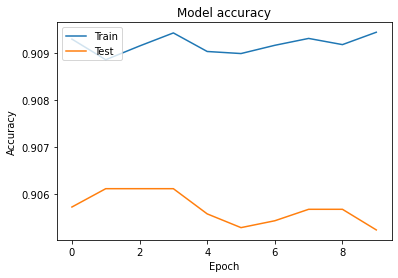

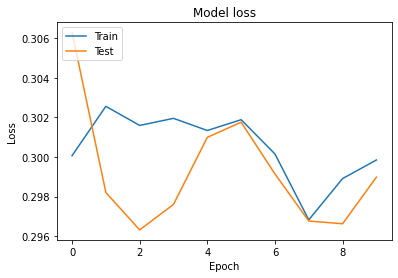

In [44]:
# Load history CHANGE HISTORY PATH HERE
history_filename = "REPLACE FILENAME"
history = pickle.load(open(PROJ_PATH +f'models/history/{history_filename}', "rb"))

# Plot training & validation accuracy values
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Outputs accuracy, F1 score, precision, recall scores

In [0]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

# Evaluates the model on the test sets based on accuracy, precision, recall, and f1 score.
def evaluate_model(model, X_test, Y_test, threshold=0.5):
    # predict probabilities for dev set
    Y_predict = model.predict(X_test, verbose=0)
    # Applying sigmoid onto prediction of probabilities in order to use f-score
    Y_predict = np.where(Y_predict > 0.3, 1, 0)

    # flatten array in order to use fscore
    Y_test_flattened = Y_test.flatten()
    Y_predict_flattened = Y_predict.flatten()

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(Y_test_flattened, Y_predict_flattened)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(Y_test_flattened, Y_predict_flattened)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(Y_test_flattened, Y_predict_flattened)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(Y_test_flattened, Y_predict_flattened)
    print('F1 score: %f' % f1)

Plots model's prediction for each `Ty` step for the `%index` example

In [0]:
# visualises model's prediction on the %index example of training input X.
def visualize_prediction(model, X, index=0):
    Y_predict = model.predict(X, verbose=0)

    plt.subplot(2, 1, 2)
    plt.plot(Y_predict[index,:,0])
    plt.ylabel('probability')
    plt.show()

Plots `Ty` for the `%index` example

In [0]:
def plot_Y(Y, index=0):
    plt.plot(Y[index])

In [22]:
evaluate_model(model, X_test, Y_test)

Accuracy: 0.954711
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


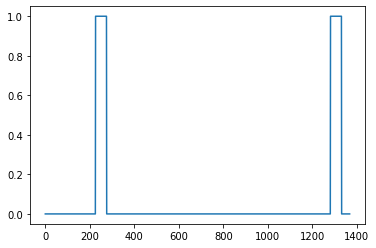

In [23]:
plot_Y(Y_test, 0)

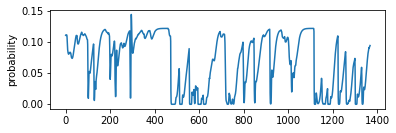

In [24]:
visualize_prediction(model, X_test, 10)

## Saving the model

In [0]:
model.save(PROJ_PATH + "models/please_save_me.h5")

## [Doesn't work] Confirming that the bias fix helps


In [0]:
zero_bias_model = create_model(input_shape = (Tx, n_freq), output_bias = None)
model_train(model, X, Y, X_dev, Y_dev)

Train on 100 samples, validate on 50 samples
Epoch 1/1
100/100 [==============================] - 109s 1s/step - loss: 1.0449 - val_loss: 0.6329


In [0]:
careful_bias_model = create_model(input_shape = (Tx, n_freq), output_bias = initial_bias)
model_train(model, X, Y, X_dev, Y_dev)

Train on 100 samples, validate on 50 samples
Epoch 1/1
100/100 [==============================] - 106s 1s/step - loss: 0.9929 - val_loss: 0.6188


In [0]:
evaluate_model(zero_bias_model, X_test, Y_test, 0.3)
evaluate_model(careful_bias_model, X_test, Y_test, 0.3)

Accuracy: 0.256947
Precision: 0.036460
Recall: 0.777778
F1 score: 0.069654
Accuracy: 0.964237
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
visualize_prediction(model, X_test)

NameError: ignored

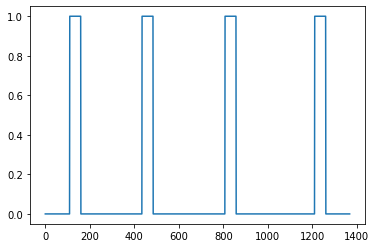

In [0]:
plt.plot(Y_test[0]) # TODO: add into evaluation tools

In [0]:
evaluate_model(model, X_test, Y_test, 0.5)

Accuracy: 0.289730
Precision: 0.166278
Recall: 0.962681
F1 score: 0.283575


Notice how there is only one sharp peak in the `careful_bias_model` but many sharp peaks in `zero_bias_model`

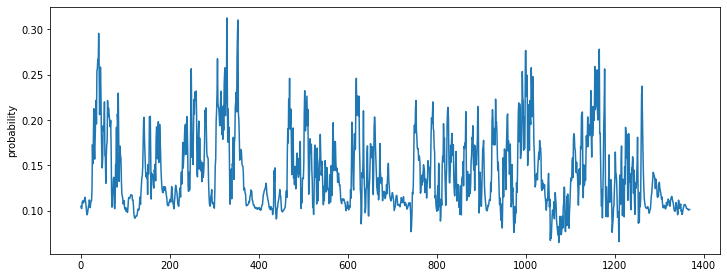

In [0]:
visualize_prediction(careful_bias_model, X_test)

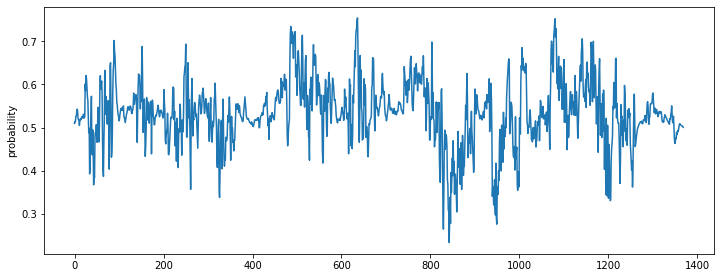

In [0]:
visualize_prediction(zero_bias_model, X_test)

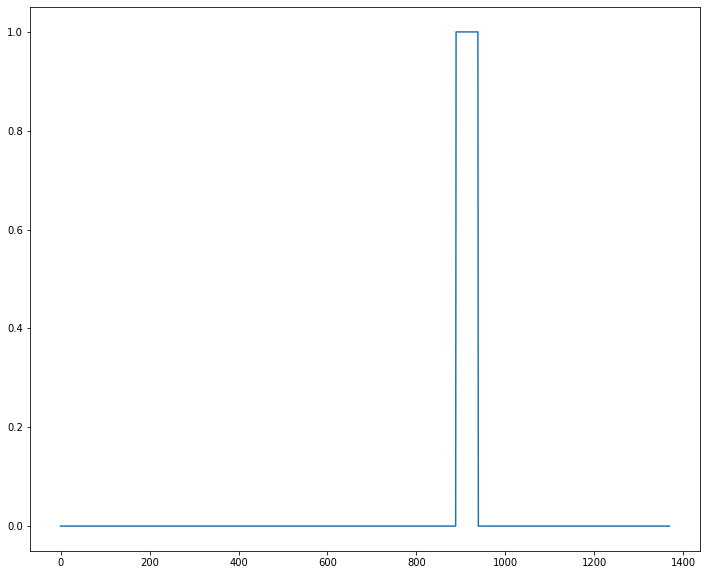

In [0]:
plt.plot(Y_test[0]) 

[Can delete the code below since `model.evaluate` is redundant now; it does not use metrics we want (ie f score)]

In [0]:
# For colab
# Function to test the model on new data
def model_test(model, X_dev, Y_dev):
    loss, acc = model.evaluate(X_dev, Y_dev)
    print("Dev set accuracy = ", acc)

In [0]:
model_test(model, X_dev, Y_dev)

50/50 [==============================] - 8s 164ms/step
Dev set accuracy =  0.9633309245109558


In [0]:
X_11 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_11X.npy")
Y_11 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_11Y.npy")
print("X: {} Y: {}".format(X_11.shape, Y_11.shape))

X_12 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_12X.npy")
Y_12 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_12Y.npy")
print("X: {} Y: {}".format(X_12.shape, Y_12.shape))

X_13 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_13X.npy")
Y_13 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_13Y.npy")
print("X: {} Y: {}".format(X_13.shape, Y_13.shape))

X_14 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_14X.npy")
Y_14 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_14Y.npy")
print("X: {} Y: {}".format(X_14.shape, Y_14.shape))








In [0]:
model_test(model, X_11, Y_11)
model_test(model, X_12, Y_12)
model_test(model, X_13, Y_13)
model_test(model, X_14, Y_14)

In [0]:
list_of_dev_ids = [11,12,13,14,20,21,22,23,24,30,31,32,33,34,35,36,37,38,39,310,40,41,42,43,44]
for id in list_of_dev_ids:
    X_id = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_" + str(id) + "X.npy")

    Y_id = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_" + str(id) + "Y.npy")
    print(("X" + str(id) + ": {} Y" + str(id) + ": {}").format(X_id.shape, Y_id.shape))
    model_test(model, X_id, Y_id)

model_test(model, X_11, Y_11)


In [0]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    print("PREPROCESSING...")
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 123000
    segment = segment.set_channels(1)
    segment = segment.set_frame_rate(123000)
    # Export as wav
    segment.export(filename, format='wav')

In [0]:
def detect_triggerword(filename):
    """
    Function to take filename and generate a prediction vector.
    
    Argument:
    filename -- Audio file to run prediction on
    
    Returns:
    predictions -- Prediction vector with probabilities
    """
    
    sample_rate, samples = wavfile.read(filename)
    _, _, x = signal.spectrogram(samples, sample_rate)
    print(x.shape)
    
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    
    predictions = model.predict(x)
    return predictions

In [0]:
def count_filler_word(filename, threshold):
    """
    Function to count the number of times trigger word spoken in audio.
    
    Arguments:
    filename -- Audio file to run prediction on
    threshold -- Probability above which trigger word considered present
    """

    preprocess_audio(filename)
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(CHIME_FILE)
    predictions = detect_triggerword(filename)
    Ty = predictions.shape[1]
    
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

In [0]:
count_filler_word('./Test_2.wav', 0.4)

PREPROCESSING...
(129, 5490)
